## Approach

   1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. Collection processed in this notebook is ODIAC CO₂ emissions version 2022.
   2. Pass the STAC item into raster API `/stac/tilejson.json` endpoint
   3. We'll visualize two tiles (side-by-side) allowing for comparison of each of the time points using `folium.plugins.DualMap`
   4. After the visualization, we'll perform zonal statistics for a given polygon.
   

## About the Data

The Open-Data Inventory for Anthropogenic Carbon dioxide (ODIAC) is a high-spatial resolution global emission data product of CO₂ emissions from fossil fuel combustion (Oda and Maksyutov, 2011). ODIAC pioneered the combined use of space-based nighttime light data and individual power plant emission/location profiles to estimate the global spatial extent of fossil fuel CO₂ emissions. With the innovative emission modeling approach, ODIAC achieved the fine picture of global fossil fuel CO₂ emissions at a 1x1km.

# Installing the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

pip install requests, folium, rasterstats, pystac_client, pandas, matplotlib, geopandas, seaborn

## Querying the STAC API

In [49]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer 
from pystac_client import Client 
import pandas as pd
import matplotlib.pyplot as plt
import branca.colormap as cm
import geopandas
from pyproj import Geod
from shapely import wkt
import seaborn as sns
import glob
import numpy as np
from datetime import datetime
from folium.plugins import MousePosition

In [51]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

STAC_API_URL_veda = "https://staging-stac.delta-backend.com"
RASTER_API_URL_veda = "https://staging-raster.delta-backend.com"

#Please use the collection name similar to the one used in STAC collection.
# Name of the collection for ODIAC dataset. 
collection_name_odiac = "odiac-ffco2-monthgrid-v2022"
collection_name_oco = "oco2geos-co2-daygrid-v10r"
collection_name_no2 = "no2-monthly"


In [32]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection_odiac = requests.get(f"{STAC_API_URL}/collections/{collection_name_odiac}").json()
collection_odiac

collection_oco2 = requests.get(f"{STAC_API_URL}/collections/{collection_name_oco}").json()
collection_oco2

collection_no2 = requests.get(f"{STAC_API_URL_veda}/collections/{collection_name_no2}").json()
collection_no2


{'id': 'no2-monthly',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'}],
 'title': 'NO₂',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2016-01-01 00:00:00+00',
     '2023-09-30 00:00:00+00']]}},
 'license': 'MIT',
 'keywords': None,
 'providers': None,
 'summaries': {'datetime': ['2016-01-01T00:00:00Z', '2023-09-30T00:00:00Z']},
 'description': 'Darker colors indicate higher nitrogen dioxide (NO₂) levels and more activity. Lighter colors indicate lower levels of NO₂ and less acti

Examining the contents of our `collection` under `summaries` we see that the data is available from January 2000 to December 2021. By looking at the `dashboard:time density` we observe that the periodic frequency of these observations is monthly. 

In [33]:
def get_item_count(STAC_API_URL, collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [34]:
# Check total number of items available
number_of_items_odiac = get_item_count(STAC_API_URL,collection_name_odiac)
items_odiac = requests.get(f"{STAC_API_URL}/collections/{collection_name_odiac}/items?limit={number_of_items_odiac}").json()["features"]
print(f"Found {len(items_odiac)} odiac items")

number_of_items_oco2 = get_item_count(STAC_API_URL,collection_name_oco)
items_oco2 = requests.get(f"{STAC_API_URL}/collections/{collection_name_oco}/items?limit={number_of_items_oco2}").json()["features"]
print(f"Found {len(items_oco2)} oco2 items")

number_of_items_no2 = get_item_count(STAC_API_URL_veda,collection_name_no2)
items_no2 = requests.get(f"{STAC_API_URL_veda}/collections/{collection_name_no2}/items?limit={number_of_items_no2}").json()["features"]
print(f"Found {len(items_no2)} no2 items")

Found 264 odiac items
Found 2615 oco2 items
Found 93 no2 items


This makes sense as there are 22 years between 2000 - 2021, with 12 months per year, meaning 264 records in total.  

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in Carbon Dioxide (CO₂) levels using the Raster API

We will explore changes in fossil fuel emissions in urban egions. In this notebook, we'll explore the impacts of these emissions and explore these changes over time. We'll then visualize the outputs on a map using `folium`. 

In [35]:
items_no2

[{'id': 'OMI_trno2_0.10x0.10_202309_Col3_V4.nc',
  'bbox': [-180.0, -90.0, 180.0, 90.0],
  'type': 'Feature',
  'links': [{'rel': 'collection',
    'type': 'application/json',
    'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'},
   {'rel': 'parent',
    'type': 'application/json',
    'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'},
   {'rel': 'root',
    'type': 'application/json',
    'href': 'https://staging-stac.delta-backend.com/'},
   {'rel': 'self',
    'type': 'application/geo+json',
    'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly/items/OMI_trno2_0.10x0.10_202309_Col3_V4.nc'}],
  'assets': {'cog_default': {'href': 's3://veda-data-store-staging/no2-monthly/OMI_trno2_0.10x0.10_202309_Col3_V4.nc.tif',
    'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
    'roles': ['data', 'layer'],
    'title': 'Default COG Layer',
    'description': 'Cloud optimized default layer to display on ma

In [36]:
# to access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items_odiac = {item["properties"]["start_datetime"][:7]: item for item in items_odiac} 
asset_name = "co2-emissions"

items_oco2 = {item["properties"]["datetime"][:10]: item for item in items_oco2} 
asset_name1 = "xco2"

items_no2 = {item["properties"]["start_datetime"][:10]: item for item in items_no2}

In [37]:
rescale_values_odiac = {"max":items_odiac[list(items_odiac.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items_odiac[list(items_odiac.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}
rescale_values_oco2 = {'max':415 , 'min': 412}
rescale_values_no2 = {'max': 9050373673124971, 'min': 0}

Now we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for January 2020 and again for January 2000, so that we can visualize each event independently. 

In [43]:
items_no2['2020-01-01']

{'id': 'OMI_trno2_0.10x0.10_202001_Col3_V4.nc',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly/items/OMI_trno2_0.10x0.10_202001_Col3_V4.nc'}],
 'assets': {'cog_default': {'href': 's3://veda-data-store-staging/no2-monthly/OMI_trno2_0.10x0.10_202001_Col3_V4.nc.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Default COG Layer',
   'description': 'Cloud optimized default layer to display on map',
   'raster:bands

In [47]:
color_map = "rainbow" # please select the color ramp from matplotlib library.
january_2020_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items_odiac['2020-01']['collection']}&item={items_odiac['2020-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values_odiac['min']},{rescale_values_odiac['max']}", 
).json()
january_2020_tile

color_map1 = "magma"
oco2_1 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items_oco2['2020-01-20']['collection']}&item={items_oco2['2020-01-20']['id']}"
    f"&assets={asset_name1}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map1}"
    f"&rescale={rescale_values_oco2['min']},{rescale_values_oco2['max']}", 
).json()
oco2_1

no2_1 = requests.get(
    f"{RASTER_API_URL_veda}/stac/tilejson.json?collection={items_no2['2020-01-01']['collection']}&item={items_no2['2020-01-01']['id']}"
    f"&assets=cog_default"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map1}"
    f"&rescale={rescale_values_no2['min']},{rescale_values_no2['max']}", 
).json()
no2_1


{'message': 'Service Unavailable'}

## Visualizing CO₂ emissions


In [48]:
sa_aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              25.519052777398997,
              -24.8470086420499
            ],
            [
              25.519052777398997,
              -28.145634397543844
            ],
            [
              30.29637465013832,
              -28.145634397543844
            ],
            [
              30.29637465013832,
              -24.8470086420499
            ],
            [
              25.519052777398997,
              -24.8470086420499
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [94]:


map_ = folium.Map(location=(-25.943840, 29.789560), zoom_start=7)

map_layer_2020 = TileLayer(
    tiles=january_2020_tile["tiles"][0],
    attr="GHG",
    name ="ODIAC",
    opacity=0.5,
)
map_layer_2020_2 = TileLayer(
    tiles=no2_1["tiles"][0],
    attr="GHG",
    name = "NO2",
    opacity=0.5,
)
sbs = folium.plugins.SideBySideLayers(layer_left=map_layer_2020, layer_right=map_layer_2020_2)
map_layer_2020.add_to(map_)
map_layer_2020_2.add_to(map_)
folium.GeoJson(sa_aoi, name="louisiana, USA").add_to(map_)
sbs.add_to(map_)
MousePosition().add_to(map_)
# visualising the map
map_

In [95]:

# Set initial zoom and center of map for CO₂ Layer
map_ = folium.Map(location=(-25.943840, 29.789560), zoom_start=7)

# December 2001
map_layer_2020_odiac = TileLayer(
    tiles=january_2020_tile["tiles"][0],
    attr="GHG",
    name ="ODIAC",
    opacity=0.5,
)
map_layer_2020_odiac.add_to(map_)

map_layer_2020_oco2 = TileLayer(
    tiles=oco2_1["tiles"][0],
    attr="GHG",
    name = "OCO2",
    opacity=0.5,
)
map_layer_2020_oco2.add_to(map_)

map_layer_2020_no2 = TileLayer(
    tiles=no2_1["tiles"][0],
    attr="GHG",
    name = "NO2",
    opacity=0.5,
)
map_layer_2020_no2.add_to(map_)

folium.GeoJson(sa_aoi, name="South Africa").add_to(map_)
folium.LayerControl(collapsed=False,position='bottomleft').add_to(map_)

# visualising the map
map_



# Calculating the zonal statistics

In [56]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name_odiac}/items?limit={number_of_items}"
).json()["features"]
print(f"Found {len(items)} items")

Found 264 items


In [63]:
# Explore one item to see what it contains
items

[{'id': 'odiac-ffco2-monthgrid-v2022-202112',
  'bbox': [-180.0, -90.0, 180.0, 90.0],
  'type': 'Feature',
  'links': [{'rel': 'collection',
    'type': 'application/json',
    'href': 'https://ghg.center/api/stac/collections/odiac-ffco2-monthgrid-v2022'},
   {'rel': 'parent',
    'type': 'application/json',
    'href': 'https://ghg.center/api/stac/collections/odiac-ffco2-monthgrid-v2022'},
   {'rel': 'root',
    'type': 'application/json',
    'href': 'https://ghg.center/api/stac/'},
   {'rel': 'self',
    'type': 'application/geo+json',
    'href': 'https://ghg.center/api/stac/collections/odiac-ffco2-monthgrid-v2022/items/odiac-ffco2-monthgrid-v2022-202112'}],
  'assets': {'co2-emissions': {'href': 's3://ghgc-data-store/odiac-ffco2-monthgrid-v2022/odiac2022_1km_excl_intl_202112.tif',
    'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
    'roles': ['data', 'layer'],
    'title': 'Fossil Fuel CO₂ Emissions',
    'proj:bbox': [-180.0, -90.0, 180.0, 90.0],
    'proj:

In [66]:
# the bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()['features']
    return {
        **result[0]["properties"],
        "start_datetime": item["properties"]["start_datetime"][:7],
    }

With the function above we can generate the statistics for the AOI.

In [68]:
%%time
stats = [generate_stats(item,sa_aoi) for item in items]

CPU times: user 3.89 s, sys: 415 ms, total: 4.3 s
Wall time: 3min 22s


In [69]:
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 630141.9375,
   'mean': 31.783989546424102,
   'count': 226908.0,
   'sum': 7212041.5,
   'std': 2946.9395581168396,
   'median': 0.0,
   'majority': 0.0,
   'minority': 2.22383713722229,
   'unique': 76767.0,
   'histogram': [[226897.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0],
    [0.0,
     63014.1953125,
     126028.390625,
     189042.578125,
     252056.78125,
     315070.96875,
     378085.15625,
     441099.34375,
     504113.5625,
     567127.75,
     630141.9375]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 226908.0,
   'percentile_2': 0.0,
   'percentile_98': 164.21135162353482}},
 'start_datetime': '2021-12'}

In [70]:
import pandas as pd

def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df

df = clean_stats(stats)
df.head(5)

,start_datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2021-12,0.0,630141.9375,31.783990,226908.0,7212041.5,2946.939558,0.0,0.0,2.223837,76767.0,"[[226897.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0,...",100.0,0.0,226908.0,0.0,164.211352,2021-12-01
1,2021-11,0.0,598590.3750,30.196780,226908.0,6851891.0,2799.385083,0.0,0.0,2.116759,76767.0,"[[226897.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0,...",100.0,0.0,226908.0,0.0,156.042750,2021-11-01
2,2021-10,0.0,582487.5625,29.398309,226908.0,6670711.5,2724.079875,0.0,0.0,2.073790,76764.0,"[[226897.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0,...",100.0,0.0,226908.0,0.0,152.020276,2021-10-01
3,2021-09,0.0,556875.1875,28.108423,226908.0,6378026.0,2604.300391,0.0,0.0,1.985412,76766.0,"[[226897.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0,...",100.0,0.0,226908.0,0.0,145.371051,2021-09-01
4,2021-08,0.0,563273.5000,28.436404,226908.0,6452447.5,2634.223532,0.0,0.0,2.013291,76766.0,"[[226897.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0,...",100.0,0.0,226908.0,0.0,147.104873,2021-08-01


## Visualizing the Data as a Time Series
We can now explore the ODIAC fossil fuel emission time series available (January 2000 -December 2021) for the Texas, Dallas area of USA. We can plot the data set using the code below:

Text(0.5, 1.0, 'CO2 emission Values for Texas, Dallas (2000-2021)')

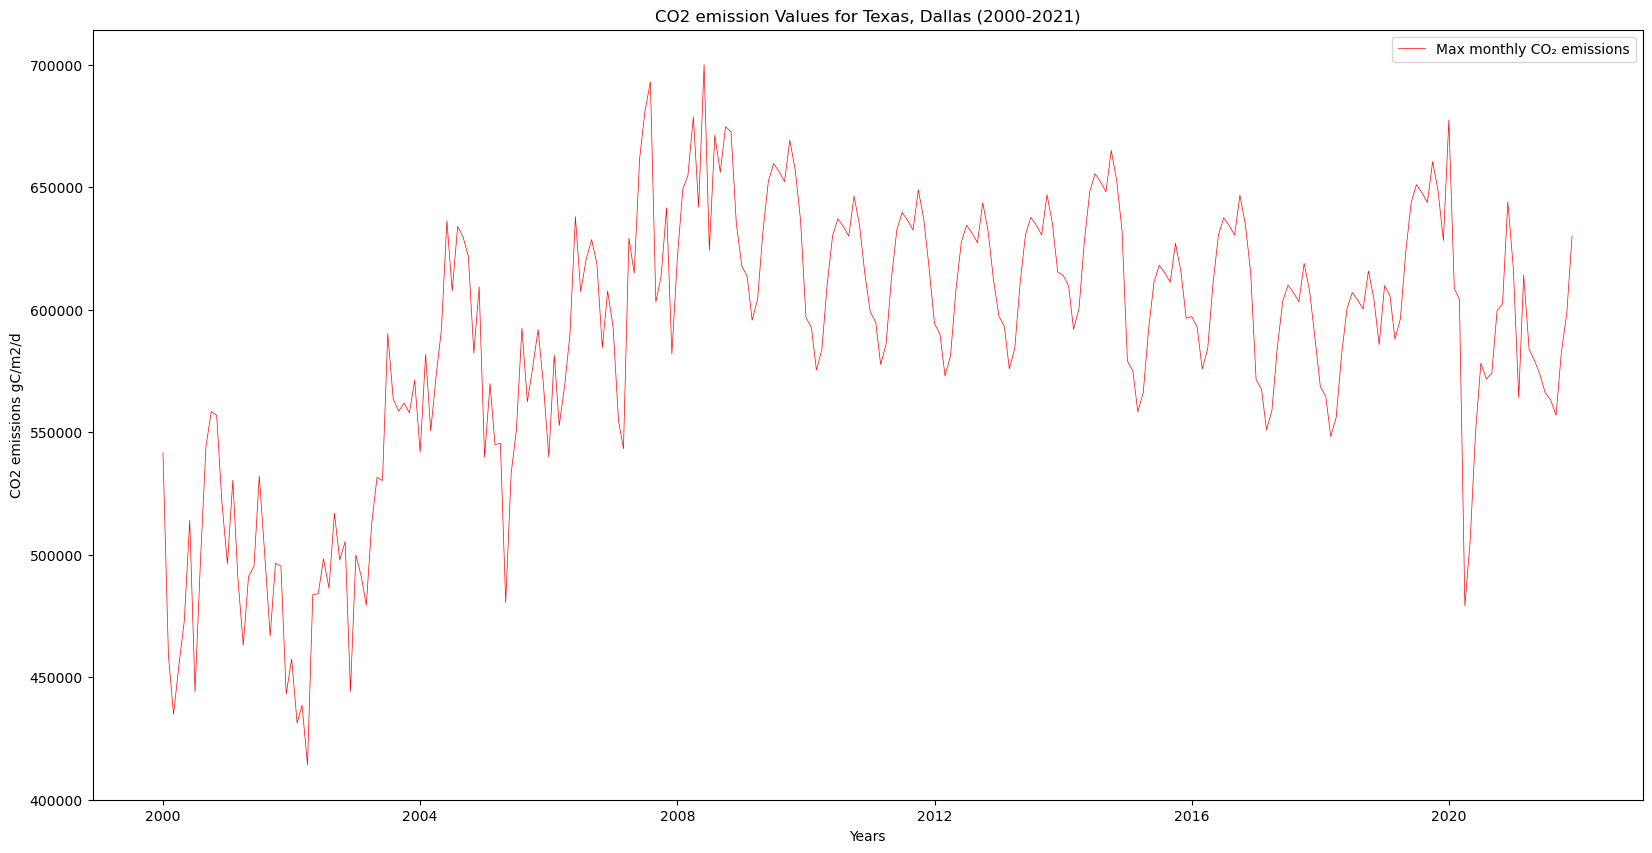

In [71]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly CO₂ emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CO2 emissions gC/m2/d")
plt.title("CO2 emission Values for South Africa (2000-2021)")

## Summary

In this notebook we have successfully explored, analysed and visualized STAC collecetion for ODIAC C02 fossisl fuel emission (2022).